<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Neuronales Convolucionales y Recurrentes </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Regularización en Redes Convolucionales.
* Diseño e implementación de redes recurrentes (RNN) usando keras.
* Diseño y entrenamiento de autoencoders (AEs)
* Transfer Learning, pre-entrenamiento (*fine tunning*).
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 1 y 4 de Junio.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Entrenamiento de RNNs en una Serie de Tiempo    
[2.](#segundo) Redes recurrentes sobre texto  
[3.](#tercero) Autoencoders (AEs) en MNIST  
[4.](#cuarto) Transfer Learning

*Nota: Para esta actividad si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*


<a id="primero"></a>
## 1. Entrenamiento de RNNs en una Serie de Tiempo
En esta sección emplearemos redes neuronales recurrentes para modelar series de tiempo, es decir una serie
de registros (tı́picamente valores reales) regularmente indexados en el tiempo. Para ello utilizaremos un dataset
denominado "*Minimum Daily Temperatures*", el cual describe la temperatura mínima diaria en un período de 10 años (1981 a 1990) en la ciudad de Melbourne, Australia. Las unidades de las 3670 observaciones fueron medidas en grados celsius. A continuación se muestra la secuencia de tiempo:
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/11/Minimum-Daily-Temperatures.png" width="60%" />



La tarea predictiva consiste en estimar la temperatura mínima diaria de algún día basado en la información de días anteriores.  
*La fuente es acreditada a Australian Bureau of Meteorology.*

> a) Escriba una función que cargue los datos, los divida en 1500 de entrenamiento y el resto (500) de pruebas. Además de esto escálelos apropiadamente para trabajar con redes recurrentes.  
```python
name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
```



In [2]:
import pandas as pd

name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
print ("\nLas dimensiones del dataframe de trabajo son:",dataframe.shape)
print ("\n\nA modo de ejemplo, se presentan los primeros registros del dataframe:\n",dataframe.head())
print ("\n\nEn resumen, se tiene un dataframe con las siguientes características:\n",dataframe.describe())



Las dimensiones del dataframe de trabajo son: (2000, 1)


A modo de ejemplo, se presentan los primeros registros del dataframe:
    Daily minimum temperatures in Melbourne, Australia, 1981-1990
0                                               20.7            
1                                               17.9            
2                                               18.8            
3                                               14.6            
4                                               15.8            


En resumen, se tiene un dataframe con las siguientes características:
        Daily minimum temperatures in Melbourne, Australia, 1981-1990
count                                        2000.000000            
mean                                           11.148250            
std                                             4.194983            
min                                             0.000000            
25%                                             8.100000      

Tal como se enuncia, el dataframe esta compuesto por 2000 registros en total, lo cuales deberán ser divididos en 1500 y 500 para el conjunto de entrenamiento y de pruebas respectivamente.   
Igualmente, es posible notar que la temperatura media en Melbourne corresponde aproximadamente a 11°C, registrando una mínima de 0°C y una máxima de 26.3°C

In [5]:
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
print ("Las dimensiones del conjunto de entrenamiento son:",df_train.shape)
print ("Las dimensiones del conjunto de pruebas son:",df_test.shape)

Las dimensiones del conjunto de entrenamiento son: (1500, 1)
Las dimensiones del conjunto de pruebas son: (500, 1)


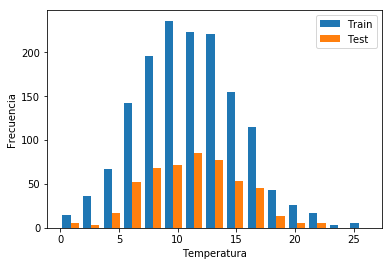

In [36]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.hist([df_train,df_test], label=["Train","Test"],bins=15)
plt.xlabel("Temperatura")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()



El histograma presentado indica la tendencia de los registros, tanto para el conjunto de entrenamiento como para el conjunto de testeo. Así es posible notar que la tendencia se encuentra entre los valores 7°C y 15°C. Situación que se aprecia mejor aún en los siguientes boxplots:

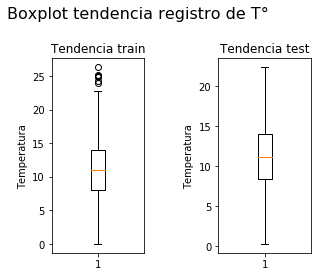

In [33]:
plt.subplot(121)
plt.boxplot(df_train)
plt.title('Tendencia train')
plt.ylabel('Temperatura')
plt.suptitle('Boxplot tendencia registro de T°', fontsize=16)


plt.subplot(122)
plt.boxplot(df_test)
plt.title('Tendencia test')
plt.ylabel('Temperatura')

plt.subplots_adjust(left=0.3, wspace=0.8, top=0.8)
plt.show()

In [7]:
#al no tener conocimiento del dominio del problema se prefiere escalalr los datos, aunque 
#al parecer no hay gran varianza o diferencia de rangos de valores entre los registros a manipular
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

print ("Nuevo mínimo: ", np.min(stream_train_scaled))
print ("Nuevo máximo: ",np.max(stream_train_scaled))

Nuevo mínimo:  0.0
Nuevo máximo:  1.0


Debido a la diferencia en los rangos de los datos, y considerando la naturaleza del problema en el que una diferencia de un par de grados es bastante significativa, éstos son escalados a un rango determinado fijo entre 0 y 1. con esto, la red recurrente estará menos propensa a sesgarse hacia los valores altos.  
Es importante destacar que el rango 0-1 fue seteado debido a que, para este caso particular, no existen temperaturas bajo 0 siendo todas ellas valores positivos. 

> b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción de la temperatura mínima para el tiempo siguiente usando la temperatura mínima de los últimos perı́odos de tiempo. El número de perı́odos de tiempos que usaremos se denomina *lag*. Por ejemplo, tendremos un *lag* igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente usamos la información del tiempo actual $x_t$ y la de los dos perı́odos anteriores $x_{t-1}$ y $x_{t-2}$ como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos *dataX* (inputs) y *dataY* (targets) donde el número de caracterı́sticas de la la matriz de entrada (columnas) sea el número de tiempos que se considerarán como información (*lag*).
```python
def create_dataset(dataset,lag=1):
    return np.array(dataX),np.array(dataY)
```
Por ejemplo si en el dataset tenemos el arreglo 20.7,17.9,18.8,14.6,15.8,15.8,10.1.
```python
create_dataset(dataset,3)
```
La función debiese generar $(X_1,X_2,X_3)$ e $Y$:


|X0|X1|X2|Y|
|---|---|---|---|
|20.7|17.9|18.8|14.6|
|17.9|18.8|14.6|15.8|
|18.8|14.6|15.8|15.8|
|14.6|15.8|15.8|10.1|




In [8]:
import numpy as np

def create_dataset(dataset,lag=1):
    dataY=dataset[lag:]
    dataX=[]
    for i in range(len(dataY)):
        dataX.append(dataset[i:lag+i])
    return np.array(dataX),np.array(dataY)

In [11]:
dataset=[20.7,17.9,18.8,14.6,15.8,15.8,10.1]

X,Y=create_dataset(dataset,3)
print("Matriz X\n",X)
print("Matriz Y\n",Y)
print ("\n\nEquivalente a\n", np.vstack((X.T,Y)))

Matriz X
 [[20.7 17.9 18.8]
 [17.9 18.8 14.6]
 [18.8 14.6 15.8]
 [14.6 15.8 15.8]]
Matriz Y
 [14.6 15.8 15.8 10.1]


Equivalente a
 [[20.7 17.9 18.8 14.6]
 [17.9 18.8 14.6 15.8]
 [18.8 14.6 15.8 15.8]
 [14.6 15.8 15.8 10.1]]


> c) Usando la función anterior genere los conjuntos de entrenamiento y test para el problema.
```python
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
```



Habiendo definido una función que crea las secuencias a utilizar a la hora de predecir los datos (con su respectivo ejemplo matricial), se presenta a continuación el formato de los datos input y target con un lag de 3 obteniendo dimensiones:

In [73]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

In [74]:
print ("Las dimensiones del conjunto X de entrenamiento son:",trainX.shape)
print ("Las dimensiones del conjunto Y de entrenamiento son:",trainY.shape)
print ("Las dimensiones del conjunto X de pruebas son:",testX.shape)
print ("Las dimensiones del conjunto Y de pruebas son:",testY.shape)

Las dimensiones del conjunto X de entrenamiento son: (1497, 3, 1)
Las dimensiones del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones del conjunto X de pruebas son: (497, 3, 1)
Las dimensiones del conjunto Y de pruebas son: (497, 1)


Lo que se traduce, de manera un poco más intuitiva, a: 

In [70]:
print ("             TrainX            || TrainY")
for i in range(5):
    print (trainX[i].T, trainY[i])

             TrainX            || TrainY
[[0.7870723 0.6806084 0.7148289]] [0.5551331]
[[0.6806084 0.7148289 0.5551331]] [0.6007605]
[[0.7148289 0.5551331 0.6007605]] [0.6007605]
[[0.5551331 0.6007605 0.6007605]] [0.6007605]
[[0.6007605 0.6007605 0.6007605]] [0.661597]


> d) En estos momentos tenemos nuestros datos en la forma [ejemplos, atributos]. Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones [*samples, time steps, features*]. Transforme el  train y test sets a la estructura deseada.
```python
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
```



In [75]:
print("Dimensiones del conjunto X de entrenamiento pre-reshape: ", trainX.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("Dimensiones del conjunto X de entrenamiento reshape: ", trainX.shape)
#time steps corresponde a las veces que samples se usará para la predicción 

Dimensiones del conjunto X de entrenamiento pre-reshape:  (1497, 3, 1)
Dimensiones del conjunto X de entrenamiento reshape:  (1497, 1, 3)


En la celda anterior se redimensionan los datos de entrenamiento y pruebas a fin de contar con la forma requerida por Keras ([samples, time steps, features]), donde el time steps (que corresponde a las veces que samples se usará para la predicción) es 1 debido a que la muestra ya contiene 3 tiempos en la secuencia de datos.

> e) Entrene una LSTM usando un lag de 3
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```



In [77]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
import os, time
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo= model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

Epoch 1/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0164
Epoch 2/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0109
Epoch 3/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0105
Epoch 4/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0103
Epoch 5/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0103
Epoch 6/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0102
Epoch 7/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0102
Epoch 8/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0101
Epoch 9/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0102
Epoch 10/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0102
Epoch 11/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0101
Epoch 12/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0101
E

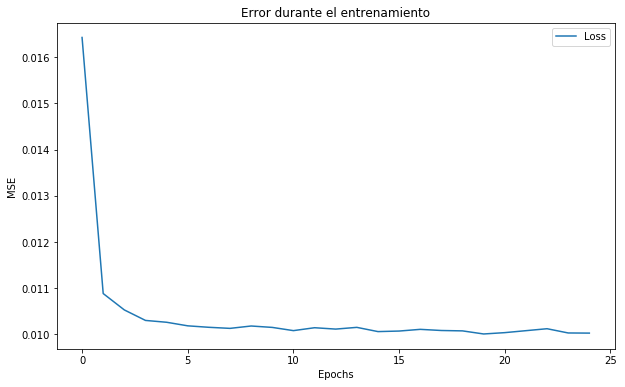

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(histo.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


En la celda anterior se entrena una red Long Short-Term Memory (LSTM) sobre los datos de entrenamiento, con función de activación tangente hiperbólica (tanh) y función de activación para las conexiones recurrentes sigmoidal (sigmoid).   
La arquitectura corresponde a una capa oculta LSTM y otra capa densa tardando 52 segundos para su entrenamiento y alcanzando valores de loss cercanos a 0.01

> f) Realice las predicciones del modelo para los conjuntos de entrenamiento y prueba. Denormalice los datos para que el error pueda ser computado en la escala original.
```python
trainPredict = model.predict(trainX,batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainP)
trainY = scaler.inverse_transform([trainY])
```



In [80]:
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())


Con un modelo ya entrenado, se procede con la predicción de temperaturas mínimas y su posterior transformación inversa a fin de recuperar el valor predecido en su escala original. Es decir, desde el rango 0-1 se transforma a escala en °C

> g) Compute el *root mean square error* (RMSE) sobre los conjuntos de entrenamiento y test, comente.

```python
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
```



In [83]:
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2.66 RMSE
Test Score: 2.46 RMSE


Se computa el error real (en escala °C), a través del RMSE observando la diferencia entre el valor predecido viendo la diferencia entre el valor predicho por la red y el valor real. Así, el error sobre el conjunto de entrenamiento es de 2.66 y sobre el conjunto de pruebas es de 2.46. Si bien, a simple vista es posible juzgar los resultaods de la red como 'aceptables', considerando el dominio del problema, podríamos recaer en que son resultados que, con un par de modificaciones al modelo, se podrían mejorar puesto que la escala en la cual se mueven los datos (tal como ya se comentó), es bastante reducida y aunque se trate de un par de grados, la diferencia será significatva.

> h) Grafique las predicciones del train y test set, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción, comente.

```python
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredic
```



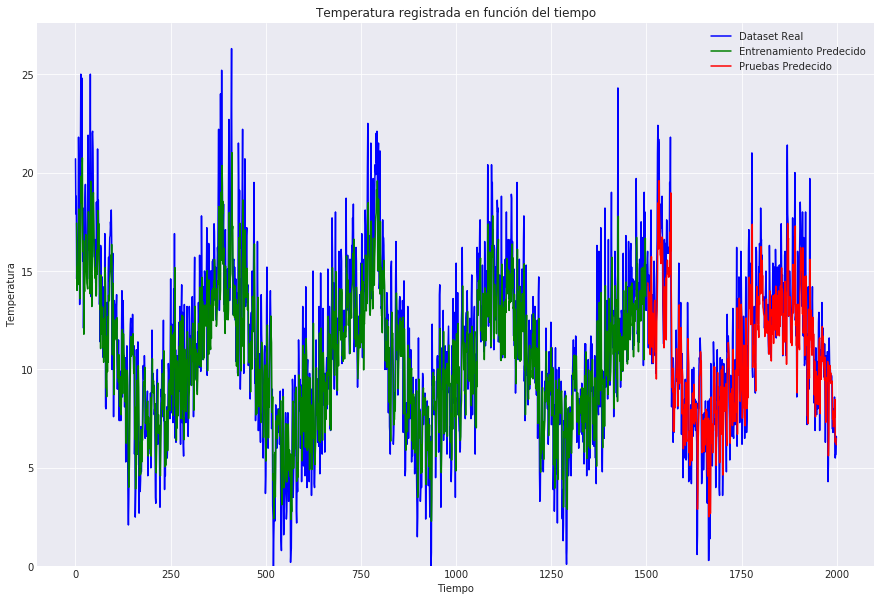

In [90]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
sns.set_style("darkgrid")

plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'g', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

La celda anterior se muestran los datos originales (azul) y los valores predichos tanto sobre el conjunto de entrenamiento como de pruebas (verde y rojo respectivamente). Tal como se espera, no se visualizan los primeros 3 datos verdes puesto que no existen datos previos para las predicciones correspondientes, por lo que la serie de predicciones es menor que la serie real. 

Igualmente, es posible notar que la aproximación del modelo es bastante cercana a la secuencia real teniendo incluso un mejor comportamiento en los datos de pruebas. Esto se pudo deber a las características del dataset de test en el que posiblemente (y en base a lo observado gráficamente) existen datos menos dispersos.  
Sin embargo, existen algunos puntos que no reflejan tan buenos resultados. Para ello se plotea a continuación una fracción de la secuencia.

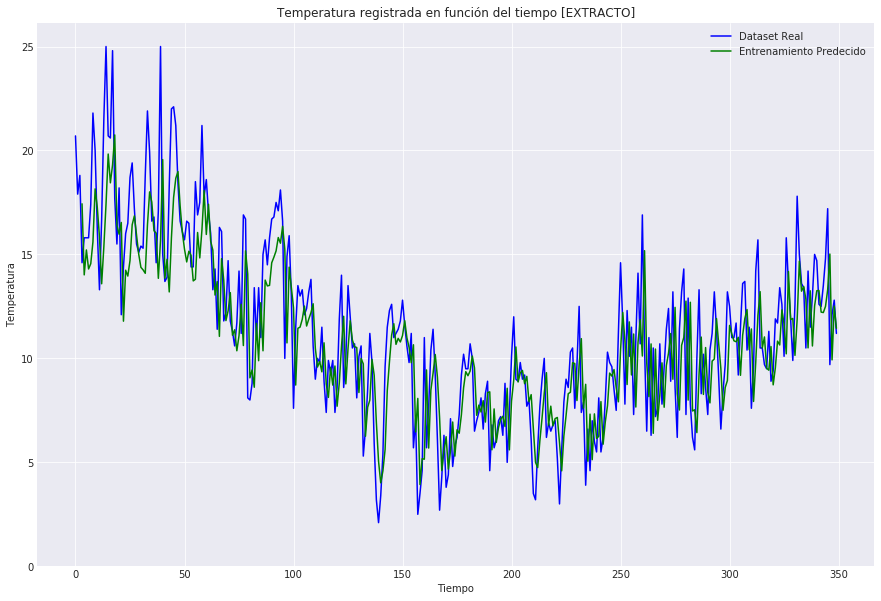

In [89]:
%matplotlib inline

plt.figure(figsize=(15, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
#testPredictPlot = np.empty_like(dataframe.values)
#testPredictPlot[:, :] = np.nan
#testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
#sns.set_style("darkgrid")
plt.plot(dataframe.values[0:350],'b', label = "Dataset Real")
plt.plot(trainPredictPlot[0:350],'g', label= "Entrenamiento Predecido")
#plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo [EXTRACTO]")
plt.legend(loc="upper right")
plt.show()

En el gráfico es posible apreciar que ciertos puntos en el tiempo no se corresponden con las predicciones del modelo, o bien, tienen un error bastante significativo. Por ejemplo: dentro de las primeras predicciones, la diferencia entre valor Real y Predicho es de 5°C aproximadamente.  
Si bien este error se aprecia en las etapas tempranas de entrenamiento (lo que es esperable en todo modelo de aprendizaje), la situación se reitera en los puntos que acusan temperaturas altas y/o bajas. Es decir, el modelo refleja se buena manera la tendencia de los datos pero tiene problemas en las situaciones "extremas".


#### NOTA
Se puede apreciar un efecto de 'desfase' respecto a los valores reales y los predichos puesto que se observa un corrimiento aparente de 1 unidad de tiempo. Este fenómeno se lo atribuiremos a la librería puesto que no tiene mayores explicaciones en cuanto al procedimiento aquí reflejado.

> i) En lugar de aumentar el número de dimensiones como el el paso e), entrene la red con un *timestep* de 3 (con dimensión de entrada 1). ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cual es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).
```python
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```



In [91]:
print("Dimensiones del conjunto X de entrenamiento pre-reshape: ", trainX.shape)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
trainX = np.reshape(trainX, (trainX.shape[0], 3, 1))
print("Dimensiones del conjunto X de entrenamiento reshape: ", trainX.shape)

Dimensiones del conjunto X de entrenamiento pre-reshape:  (1497, 1, 3)
Dimensiones del conjunto X de entrenamiento reshape:  (1497, 3, 1)


Ahora se varía el shape del dataframe de entrenamiento a timestep de 3 con dimensión de entrada 1. Es decir, samples será utilizado 3 veces antes de una predicción.

In [20]:
model = Sequential()
model.add(LSTM(4, activation='tanh', input_shape=(None, 1), recurrent_activation='sigmoid'))
model.add(Dense(1))

In [21]:
import os,time
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo2=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

Epoch 1/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0272
Epoch 2/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0122
Epoch 3/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0116
Epoch 4/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0113
Epoch 5/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0110
Epoch 6/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0106
Epoch 7/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0105
Epoch 8/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0104
Epoch 9/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0103
Epoch 10/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 11/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0102
Epoch 12/25
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0103
E

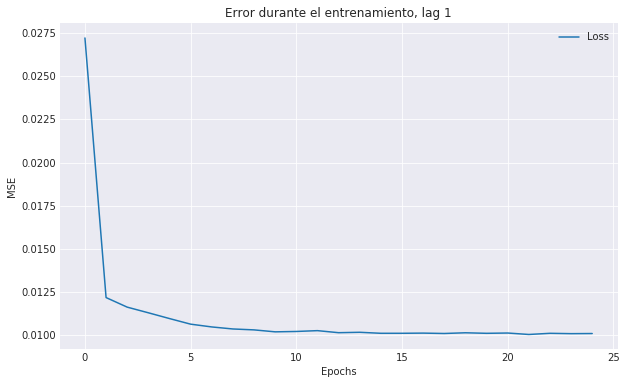

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10, 6))
plt.plot(histo2.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento, lag 1")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [23]:
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())


In [24]:
testX = np.reshape(testX, (testX.shape[0], 3, 1))
testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

In [25]:
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE


A pesar de tardar mayor tiempo su entrenamiento (pasando de 52 a 65 segundos), se puede apreciar una leve mejora en términos de RMSE para este último modelo. Por ello, se considera que el uso de lag=1 con timestep=3 cae en mejores resultados que lag=3 y timestep=1.   
Sin embargo, debido a que la mejora no es tan significativa en comparación a la inversión de tiempo extra (más de un 10% más), se procederá a continuación en base a lag=3 y timestep=1

### LSTM, unidades variables

> j) Determine el parámetro del número de bloques para la LSTM de la pregunta e) o i), lo que le parezca mas sensato en base a lo analizado en la pregunta anterior. Utilice 5-fold *cross validation*, o bien, en su defecto, los datos restante no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante) como conjunto fijo de validación. Comente.
```python
nb = range(4,13,2)
model = Sequential()
model.add(LSTM(nb=range(4,13,2),input_dim=choose,activation='tanh',inner_activation='sigmoid'))
model.add(Dense(1))
```



In [99]:
##retornando a shape previo 
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(1497, 1, 3)


In [27]:
from sklearn.model_selection import KFold
nb=list(np.arange(4,13,2))
lag=3     

for unidades in nb:                                                                    
    kf = KFold(n_splits=5)
    errores = []
    tiempos = []
    for train, val in kf.split(trainX):#por cada fold
        model = Sequential()
        model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
        model.add(Dense(1,activation='linear'))
        inicio = time.time()
        model.compile(loss='mean_squared_error', optimizer='adam')
        histo= model.fit(trainX[train], trainY[train], epochs=25, batch_size=1, verbose=0)
    
        trans=(time.time() - inicio )
        print("Tiempo que requirió el entrenamiento del kfold:",trans)
        tiempos.append(trans) 
        
        batch_size=1  
        trainPredict = model.predict(trainX[val], batch_size=batch_size)
        trainPredict = scaler.inverse_transform(trainPredict) 
        trainY_ds = scaler.inverse_transform(trainY[val].copy())
        error= np.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))  
        errores.append(error)       
        
    print("Loss con", unidades,"bloques:",np.mean(errores),"en",np.mean(tiempos),"segundos") 
    

    

/home/cony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/cony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 3), recurrent_activation="sigmoid")`
  # This is added back by InteractiveShellApp.init_path()


Tiempo que requirió el entrenamiento del kfold: 34.930391788482666
Tiempo que requirió el entrenamiento del kfold: 35.35994505882263
Tiempo que requirió el entrenamiento del kfold: 35.34766173362732
Tiempo que requirió el entrenamiento del kfold: 35.728049755096436
Tiempo que requirió el entrenamiento del kfold: 36.18724870681763
Loss con 4 bloques: 2.642354 en 35.51065940856934 segundos
Tiempo que requirió el entrenamiento del kfold: 36.464158058166504
Tiempo que requirió el entrenamiento del kfold: 36.87334132194519
Tiempo que requirió el entrenamiento del kfold: 37.50871205329895
Tiempo que requirió el entrenamiento del kfold: 37.74355220794678
Tiempo que requirió el entrenamiento del kfold: 38.03239893913269
Loss con 6 bloques: 2.640032 en 37.32443251609802 segundos
Tiempo que requirió el entrenamiento del kfold: 38.62162804603577
Tiempo que requirió el entrenamiento del kfold: 38.69121265411377
Tiempo que requirió el entrenamiento del kfold: 39.22007465362549
Tiempo que requirió e

En la celda anterior se varía el número de bloques para la LSTM de la pregunta anterior utilizando 5-fold cross validation. Con este proceso se aprecia que la mejor configuración corresponde a la que hace uso de 6 bloques de unidades en la capa LSTM puesto que es la que acusa menor loss y un tiempo de entrenamiento aceptable. 

In [100]:
##el mejor fue con 6 unidades, entrenar red con 6 y mostrar el error sobre test (lag 3)

lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
model = Sequential()
model.add(LSTM(6, activation='tanh', input_shape=(None, lag), recurrent_activation="sigmoid"))
model.add(Dense(1,activation='linear'))
print (model.summary())
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo= model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

(1497, 1, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6)                 240       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 247
Trainable params: 247
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1497/1497 [==============================] - 2s 2ms/step - loss: 0.0381
Epoch 2/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0121
Epoch 3/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0110
Epoch 4/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0105
Epoch 5/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0105
Epoch 6/25
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0103
Epoch 7/25
1497/1497 [==

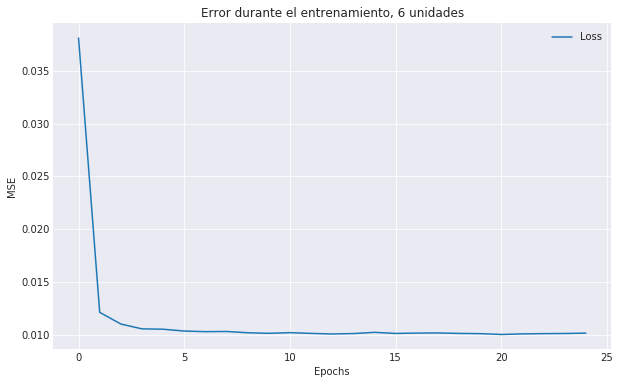

Train Score: 2.61 RMSE
Test Score: 2.41 RMSE


In [101]:

import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10, 6))
plt.plot(histo.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento, 6 unidades")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Se aprecia entonces que con 6 unidades en LSTM se loogra obtener mejores resultados que los expuestos anteriormente y en una cantidad de 52 segundos, lo que deja en evidencia la mejora en cuanto a rendimiento del modelo.  
Esto se aprecia muy sutilmente en el siguiente gráfico:

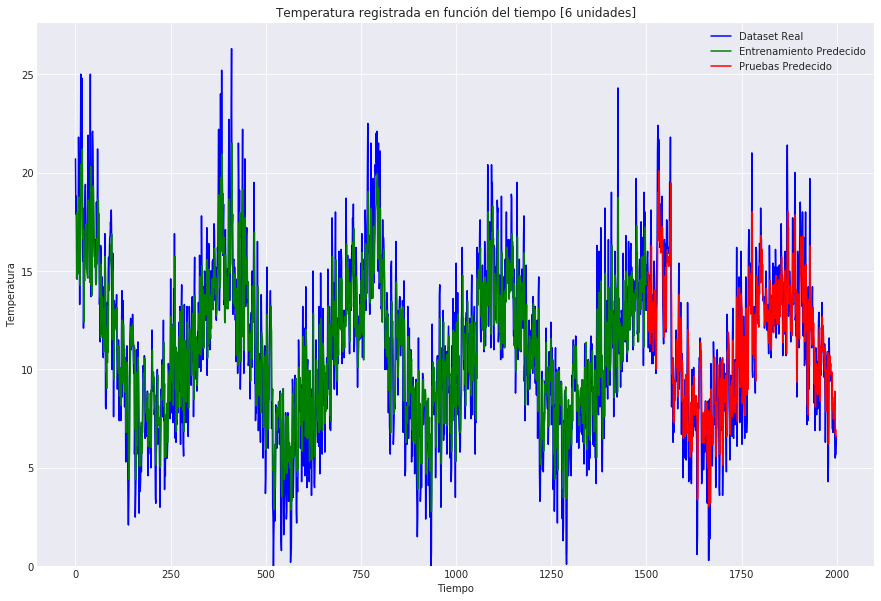

In [102]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
sns.set_style("darkgrid")

plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'g', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo [6 unidades]")
plt.legend(loc="upper right")
plt.show()

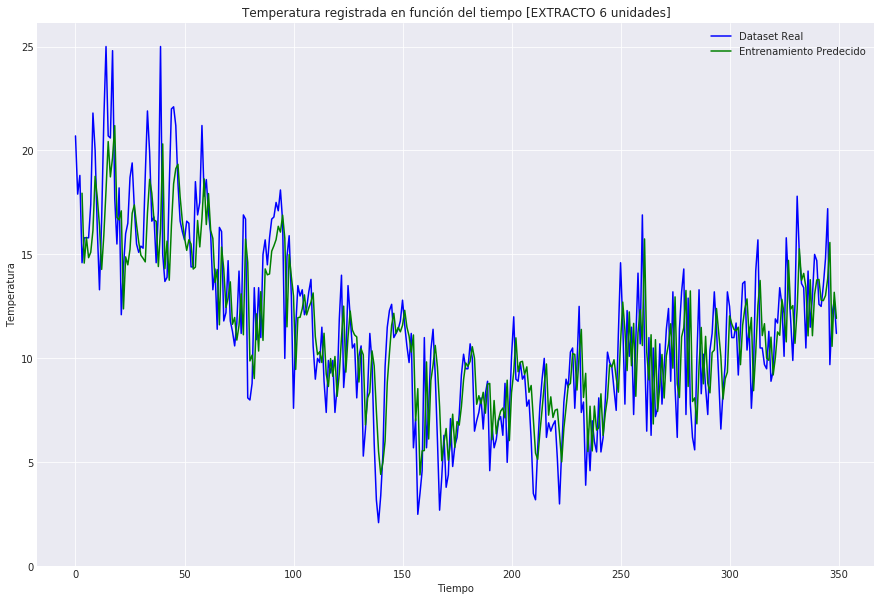

In [105]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
"""testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
sns.set_style("darkgrid")"""

plt.plot(dataframe.values[0:350],'b', label = "Dataset Real")
plt.plot(trainPredictPlot[0:350],'g', label= "Entrenamiento Predecido")
#plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo [EXTRACTO 6 unidades]")
plt.legend(loc="upper right")
plt.show()

Es notable nuevamente el buen ajuste entre los valores reales a los valores predichos por el modelo pero esta vez con diferencias de temperatura no tan grandes/evidentes como los modelos previos. Así entonces, en las zonas más "extremas", si bien no calzan perfectamente, suelen aproximarse mejor.

> k) Compare el desempeño de la red LSTM variando el lag de 1 a 4. Comente brevemente sobre qué resulta mejor, el tener mas información para predecir o si esto satura la predicción por el efecto del gradiente desvaneciente.



###### Utilizando validation set 

Se define a continación el dataframe de validación que corresponde a los datos restantes no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante).

In [106]:
df = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[2000:]
print ("\nLas dimensiones del dataframe de validación son:",df.shape)
df[:] = df[:].astype('float32')
df_val = df.values


Las dimensiones del dataframe de validación son: (1650, 1)


In [107]:
stream_val_scaled = scaler.transform(df_val)

### Variando LAGs y fijando unidades=6


In [108]:
#lag = 3
unidades=6

def crear_datos_lag(stream_train_scaled, stream_val_scaled, lag):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    valX, valY = create_dataset(stream_val_scaled, lag)
    '''print ("Las dimensiones del conjunto X de entrenamiento son:",trainX.shape)
    print ("Las dimensiones del conjunto Y de entrenamiento son:",trainY.shape)
    print ("Las dimensiones del conjunto X de validación son:",valX.shape)
    print ("Las dimensiones del conjunto Y de validación son:",valY.shape)'''
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
    print ("Las dimensiones finales del conjunto X de entrenamiento son:",trainX.shape)
    print ("Las dimensiones finales del conjunto Y de entrenamiento son:",trainY.shape)
    print ("Las dimensiones finales del conjunto X de validación son:",valX.shape)
    print ("Las dimensiones finales del conjunto Y de validación son:",valY.shape)
    
    return trainX, trainY,valX, valY



In [109]:
lags = [1,2,3,4]

for lag in lags:
    print ("\nCon un lag equivalente a:", lag)
    trainX,trainY,valX,valY = crear_datos_lag(stream_train_scaled, stream_val_scaled, lag)
    model = Sequential()
    model.add(LSTM(unidades, activation='tanh',  input_shape=(None, lag), recurrent_activation="sigmoid"))
    model.add(Dense(1,activation='linear'))
    inicio = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
    print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
    batch_size=1  
    trainPredict = model.predict(trainX, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict) 
    trainY_ds = scaler.inverse_transform(trainY.copy())

    valPredict = model.predict(valX, batch_size=batch_size)
    valPredict = scaler.inverse_transform(valPredict)
    valY_ds = scaler.inverse_transform(valY.copy())

    trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    valScore = math.sqrt(mean_squared_error(valY_ds, valPredict[:,0]))
    print('Val Score: %.2f RMSE' % (valScore))



Con un lag equivalente a: 1
Las dimensiones finales del conjunto X de entrenamiento son: (1499, 1, 1)
Las dimensiones finales del conjunto Y de entrenamiento son: (1499, 1)
Las dimensiones finales del conjunto X de validación son: (1649, 1, 1)
Las dimensiones finales del conjunto Y de validación son: (1649, 1)
Tiempo que requirió el entrenamiento: 45.248869
Train Score: 2.71 RMSE
Val Score: 2.52 RMSE

Con un lag equivalente a: 2
Las dimensiones finales del conjunto X de entrenamiento son: (1498, 1, 2)
Las dimensiones finales del conjunto Y de entrenamiento son: (1498, 1)
Las dimensiones finales del conjunto X de validación son: (1648, 1, 2)
Las dimensiones finales del conjunto Y de validación son: (1648, 1)
Tiempo que requirió el entrenamiento: 47.030148
Train Score: 2.70 RMSE
Val Score: 2.52 RMSE

Con un lag equivalente a: 3
Las dimensiones finales del conjunto X de entrenamiento son: (1497, 1, 3)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones 

En la celda anterior se varía el lag entre 1 y 4 para generar las secuencias observando el RMSE con cross validation de 5 fold, asociado al tiempo de entrenamiento del modelo.  
Es posible apreciar que a medida que aumenta el lag, aumenta el tiempo de entrenamiento (excepto lag=4). Esto se debe a que en la medida que aumente el lag, la cantidad de atributos (valores de días previos) aumentará, traduciéndose en un aumento de características que deberá manipular el modelo.  


En este caso, el mejor desempeño lo obtiene el modelo con lag igual a 4, con RMSE 2.60 y 2.43 para los conjuntos de entrenamiento y validación respectivamente y cuyo tiempo de entrenamiento es comparable al modelo de lag=2. 


### Modelo escogido:

In [111]:
#Lag de 4 y 6 unidades para LSTM
#modelar para obtener error en test
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import time, math

lag=4
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,testX,testY = crear_datos_lag(stream_train_scaled, stream_test_scaled, lag)
model = Sequential()
model.add(LSTM(6, activation='tanh',input_shape=(None, lag), recurrent_activation="sigmoid"))
model.add(Dense(1,activation='linear'))
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))


Con un lag equivalente a: 4
Las dimensiones finales del conjunto X de entrenamiento son: (1496, 1, 4)
Las dimensiones finales del conjunto Y de entrenamiento son: (1496, 1)
Las dimensiones finales del conjunto X de validación son: (496, 1, 4)
Las dimensiones finales del conjunto Y de validación son: (496, 1)
Tiempo que requirió el entrenamiento: 46.868206
Train Score: 2.617 RMSE
Test Score: 2.418 RMSE


Se observa que el rendimiento de la red se mantiene para el conjunto de pruebas, obteniendo RMSE de 2.418. Cabe destacar que éste no es el menor registrado durante toda la experimentación puesto que en base a una capa LSTM con lag igual a 3 y 6 bloques de unidades de salida, se logra RMSE 2.41

### Red recurrente simple vs GRU

> l) Usando un lag de 3, compare el desempeño de la LSTM con una red recurrente simple y una GRU. Comente sobre la convergencia y el tiempo de ejecución.
```python
from keras.layers import GRU
from keras.layers import SimpleRNN
GRU(output_dim, inner_init='orthogonal', activation='tanh')
SimpleRNN(output_dim, inner_init='orthogonal',activation='tanh')
```



In [112]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.metrics import mean_squared_error
import time, math

lag=3
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,testX,testY = crear_datos_lag(stream_train_scaled, stream_test_scaled, lag)


Con un lag equivalente a: 3
Las dimensiones finales del conjunto X de entrenamiento son: (1497, 1, 3)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones finales del conjunto X de validación son: (497, 1, 3)
Las dimensiones finales del conjunto Y de validación son: (497, 1)


#### Red Recurrente Simple

In [115]:
model = Sequential()
model.add(SimpleRNN(units=6, input_shape=(None, 3), activation='tanh', recurrent_initializer='orthogonal'))
model.add(Dense(1, activation = 'linear'))

inicio = time.time() 
model.compile(loss='mean_squared_error', optimizer='adam')
histRNN= model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Tiempo que requirió el entrenamiento: 155.196645
Train Score: 2.621 RMSE
Test Score: 2.415 RMSE


#### Red Recurrente GRU

In [116]:
modelg = Sequential()
modelg.add(GRU(units=6, input_shape=(None,3), recurrent_initializer='orthogonal', activation='tanh'))
modelg.add(Dense(1, activation = 'linear'))

inicio = time.time() 
modelg.compile(loss='mean_squared_error', optimizer='adam')
histGRU= modelg.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

batch_size=1  
trainPredict = modelg.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = modelg.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Tiempo que requirió el entrenamiento: 205.558163
Train Score: 2.633 RMSE
Test Score: 2.436 RMSE



En las celdas anteriores se entrenan los modelos de redes recurrentes SimpleRNN y GRU acusando sus errores RMSE respectivos sobre training set y testing set.  
Se puede apreciar que SimpleRNN supera en términos de desempeño a GRU obteniendo RMSE (train/Test) de 2.621/2.415 vs 2.633/2.436  
Además cabe mencionar que el entrenamiento de SimpleRNN requirió menos tiempo, sólo 155 segundos mientras que GRU hizo uso de 205 segundos. Esto se puede explicar desde el punto de vista del manejo de la información dentro del modelo: 

-  GRU tiene dos compuertas (reseteo y actualización) mientras que LSTM tiene tres compuertas (entrada, salida y de olvido).
-  La unidad GRU controla el flujo de información como la LSTM pero sin usar una unidad de memoria. Simplemente expone todo el contenido oculto sin ningún control.


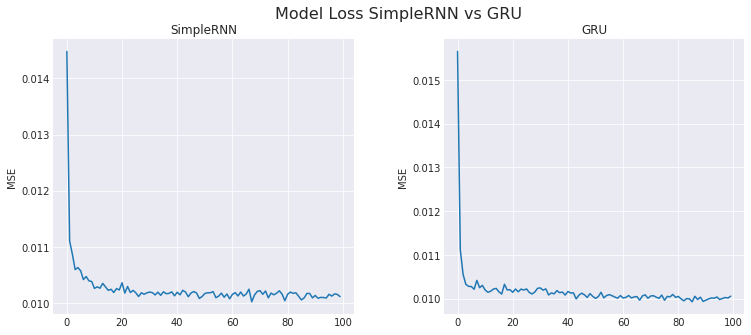

In [137]:
### hacer grfico para convergencia de loss 
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(histRNN.history['loss'])
plt.title('SimpleRNN')
plt.ylabel('MSE')
plt.suptitle('Model Loss SimpleRNN vs GRU', fontsize=16)


plt.subplot(122)
plt.plot(histGRU.history['loss'])
plt.title('GRU')
plt.ylabel('MSE')

plt.subplots_adjust(left=0.1, wspace=0.3, top=0.89)
plt.show()

En cuanto a la convergencia de estos dos modelos entrenados, es correcto mencionar que GRU tiene mayor capacidad de convergencia hacia los valores esperados/correctos de manera más temprana. Esto es, dentro de los primeros epochs, en los cuales el aprendizaje del modelo es bastante pobre, GRU obtiene menor RMSE que SimpleRNN. Pero, según indican los resultados obtenidos, el error cuadrático medio de éste último es menor al de GRU.


Aún así, ninguna de estas variantes supera al modelo con LSTM de lag=3, timestamp=1 y 6 unidades de salida.

> m) Entrene la red LSTM con memoria entre batches. Grafique las predicción, comente si de esta forma mejora la predicción.
```python
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
```


In [139]:
def crear_datos_lag2(stream_train_scaled, stream_val_scaled, lag):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    valX, valY = create_dataset(stream_val_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1],1))
    print ("Las dimensiones finales del conjunto X de entrenamiento son:",trainX.shape)
    print ("Las dimensiones finales del conjunto Y de entrenamiento son:",trainY.shape)
    print ("Las dimensiones finales del conjunto X de validación son:",valX.shape)
    print ("Las dimensiones finales del conjunto Y de validación son:",valY.shape)
    
    return trainX, trainY,valX, valY


In [143]:
lag=3
batch_size = 1
print ("\nCon un lag equivalente a:", lag, "y batch-size de:", batch_size)

trainX,trainY,testX,testY = crear_datos_lag2(stream_train_scaled, stream_test_scaled, lag)
modelL6 = Sequential()
modelL6.add(LSTM(6, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
modelL6.add(Dense(1,activation='linear'))
modelL6.compile(loss='mean_squared_error', optimizer='adam')

inicio = time.time()
for i in range(25):
    modelL6.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    modelL6.reset_states()
    
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

trainPredict = modelL6.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())
testPredict = modelL6.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))


Con un lag equivalente a: 3 y batch-size de: 1
Las dimensiones finales del conjunto X de entrenamiento son: (1497, 3, 1)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones finales del conjunto X de validación son: (497, 3, 1)
Las dimensiones finales del conjunto Y de validación son: (497, 1)
Tiempo que requirió el entrenamiento: 57.394525
Train Score: 3.267 RMSE
Test Score: 3.039 RMSE


In [142]:
modelL675 = Sequential()
modelL675.add(LSTM(6, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
modelL675.add(Dense(1,activation='linear'))
modelL675.compile(loss='mean_squared_error', optimizer='adam')

inicio = time.time()
for i in range(75):
    modelL675.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    modelL675.reset_states()
    
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

trainPredict = modelL675.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = modelL675.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Tiempo que requirió el entrenamiento: 167.253408
Train Score: 2.947 RMSE
Test Score: 2.743 RMSE


In [144]:
modelL6100 = Sequential()
modelL6100.add(LSTM(6, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
modelL6100.add(Dense(1,activation='linear'))
modelL6100.compile(loss='mean_squared_error', optimizer='adam')

inicio = time.time()
for i in range(100):
    modelL6100.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    modelL6100.reset_states()
    
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

trainPredict = modelL6100.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = modelL6100.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Tiempo que requirió el entrenamiento: 234.145943
Train Score: 2.933 RMSE
Test Score: 2.746 RMSE


En las celdas anteriores se entrena una red con manejo de memoria entre batches. Esto se aprecia directamente al setear el parámetro 'stateful=True' en la definición del modelo además del reseteo de estados en cada ajuste (fit) de un epoch. 

El modelo Stateful funciona de modo tal que se guardan los pesos de la red recurrente para el próximo elemento del batch en el mismo índice el dato analizado. Cabe destacar que esto sólo será util siempre y cuando el orden de los elementos no sea intervenido (shuffle= False) permitiéndole al modelo aprender y/o derviar las dependencias a través del tiempo en los datos observados.
Dicho de otro modo, en el modelo Stateful todos los estados se propagan al siguiente batch significando que el estado de la muestra ubicada en el índice i, Xi, se utilizará como estado incial en el cálculo de la muestra Xi + |B| en el siguiente batch, donde |B| es el tamaño del batch (sin randomización de elementos).


Esta esta variante, se obtienen resultados interesantes pero no mejores comparado a las redes entrenadas anteriormente, por lo que, a pesar de que almacena los pesos del modelo/estado de cada ejemplo en la secuencia, un modelo LSTM stateless sigue arrojando mejores resultados aunque sería imposible asegurar que éste identifica dependencias en el tiempo. 


http://philipperemy.github.io/keras-stateful-lstm/

> n) Compare el resultado anterior usando un tamaño de batch, decidido por usted, mayor o igual a 3.  


In [146]:
unids= 6
trainX,trainY,testX,testY = crear_datos_lag2(stream_train_scaled, stream_test_scaled, lag)
###497 se puede dividir por : 1, 7, 71, 497
###1497 se puede dividir por : 1, 3, 499, 1497---
###para 1496--> 1, 2, 4, 8, 11, 17
###para 496.--> 1, 2, 4, 8, 16, 31


Las dimensiones finales del conjunto X de entrenamiento son: (1497, 3, 1)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones finales del conjunto X de validación son: (497, 3, 1)
Las dimensiones finales del conjunto Y de validación son: (497, 1)


Debido al número de datos que componían a los conjuntos de entrenamiento y pruebas (1497 y 497), el dividir dichas cantidades en batches de tamaño fijo requería eliminar un elemento de la secuencia. Así, 1496 y 496 compartirían un tamaño (divisor común) de batch fijo común. Estos se trataban de 2, 4 y 8 pero, debido a la restricción 'mayor a 3', se decidió fijar como tamaños de batches a 4 y 8.

In [147]:
trainX2= trainX[0:1496].copy()
trainY2= trainY[0:1496].copy()
testX2= testX[0:496].copy()
testY2= testY[0:496].copy()

print ("Las dimensiones finales del conjunto X de entrenamiento son:",trainX2.shape)
print ("Las dimensiones finales del conjunto Y de entrenamiento son:",trainY2.shape)
print ("Las dimensiones finales del conjunto X de validación son:",testX2.shape)
print ("Las dimensiones finales del conjunto Y de validación son:",testY2.shape)

Las dimensiones finales del conjunto X de entrenamiento son: (1496, 3, 1)
Las dimensiones finales del conjunto Y de entrenamiento son: (1496, 1)
Las dimensiones finales del conjunto X de validación son: (496, 3, 1)
Las dimensiones finales del conjunto Y de validación son: (496, 1)


In [148]:
batch_sizes=[4,8]
lag=3
testpredictsM=[]
trainpredictsM=[]
for batch_size in batch_sizes:
    print ("\nUtilizando batch_size de", batch_size, "y un total de unidades de", unids)
    model = Sequential()
    model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    total=75
    inicio = time.time()
    for i in range(total):
        model.fit(trainX2, trainY2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
    trainPredict = model.predict(trainX2, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict) 
    trainY_ds = scaler.inverse_transform(trainY2.copy())
    testPredict = model.predict(testX2, batch_size=batch_size)
    testPredict = scaler.inverse_transform(testPredict)
    testY_ds = scaler.inverse_transform(testY2.copy())
    trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
    print('Test Score: %.3f RMSE' % (testScore))
    trainpredictsM.append(trainPredict)
    testpredictsM.append(testPredict)


Utilizando batch_size de 4 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 45.707730
Train Score: 2.567 RMSE
Test Score: 2.387 RMSE

Utilizando batch_size de 8 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 24.525224
Train Score: 2.559 RMSE
Test Score: 2.374 RMSE


In [149]:
batch_sizes=[4,8]
print ("Sin uso de memoria, Statefulness")
lag=3
testpredicts=[]
trainpredicts=[]
for batch_size in batch_sizes:
    print ("\nUtilizando batch_size de", batch_size, "y un total de unidades de", unids)
    model = Sequential()
    model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=False, activation='tanh' , recurrent_activation='sigmoid'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    total=75
    inicio = time.time()
    for i in range(total):
        model.fit(trainX2, trainY2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
    trainPredict = model.predict(trainX2, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict) 
    trainY_ds = scaler.inverse_transform(trainY2.copy())
    testPredict = model.predict(testX2, batch_size=batch_size)
    testPredict = scaler.inverse_transform(testPredict)
    testY_ds = scaler.inverse_transform(testY2.copy())
    trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
    print('Train Score: %.3f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
    print('Test Score: %.3f RMSE' % (testScore))
    trainpredicts.append(trainPredict)
    testpredicts.append(testPredict)

Sin uso de memoria, Statefulness

Utilizando batch_size de 4 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 46.582666
Train Score: 2.625 RMSE
Test Score: 2.425 RMSE

Utilizando batch_size de 8 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 24.696721
Train Score: 2.616 RMSE
Test Score: 2.415 RMSE


Al utilizar tamaño de batch igual a 4 y 8, en la misma red definida anteriormente, se obtienen errores más bajos tanto sobre el conjunto de entrenamiento como el de pruebas. Esto se debe a que existe una mayor cantidad de información con la cual el modelo dispone a la hora de realizar sus predicciones en cada uno de los batches. 

Esto es: 

- Modelo Stateful, Batch size=1 
-- Train Score: 2.947 RMSE ; Test Score: 2.743 RMSE

- Modelo Stateful, Batch size=4
-- **Train Score: 2.567 RMSE ; Test Score: 2.387 RMSE**

- Modelo Stateful, Batch size=8
-- **Train Score: 2.559 RMSE ; Test Score: 2.374 RMSE**

- Modelo Statefulness + reset, Batch size=4
-- Train Score: 2.625 RMSE ; Test Score: 2.425 RMSE

- Modelo Statefulness + reset, Batch size=8
-- Train Score: 2.616 RMSE ; Test Score: 2.415 RMSE


siendo el modelo Stateful de Batch size=8 con reseteo el que impone los mejores resultados en la experimentación. Aunque su variante de Batch size=4 logra desempeños casi iguales en el doble del tiempo de entrenamiento puesto que consta de una mayor cantidad de samples. 

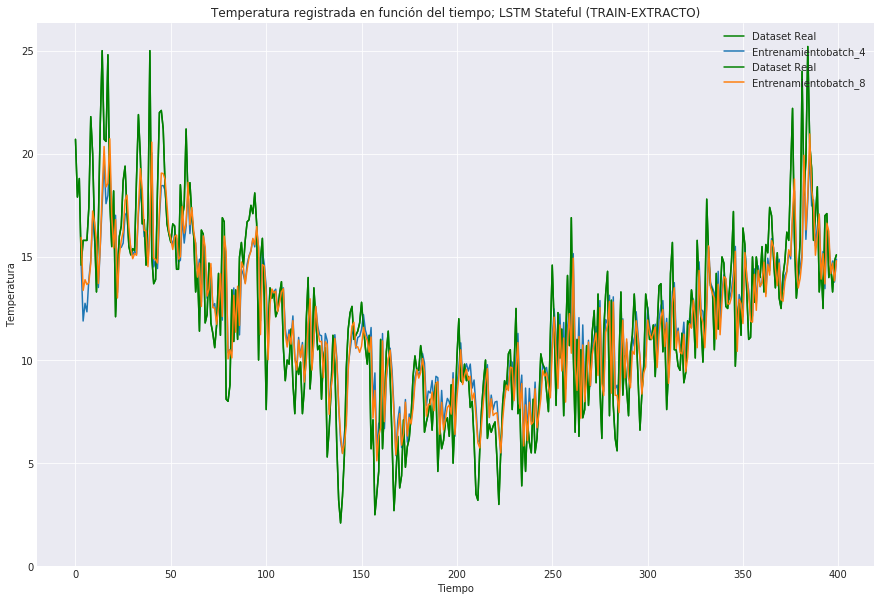

In [154]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(15, 10))
etiquetas=["batch_4", "batch_8"]
for i in range(2):    
    trainPredict=trainpredictsM[i]
    testPredict=testpredictsM[i]
    trainPredictPlot = np.empty_like(dataframe.values)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lag:len(trainPredict)+lag, :][0:1496] = trainPredict
    sns.set_style("darkgrid")

    plt.plot(dataframe.values[0:400],'g',label = "Dataset Real")
    plt.plot(trainPredictPlot[0:400], label= "Entrenamiento"+etiquetas[i])
    
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo; LSTM Stateful (TRAIN-EXTRACTO)")
plt.legend(loc="upper right")
plt.show()

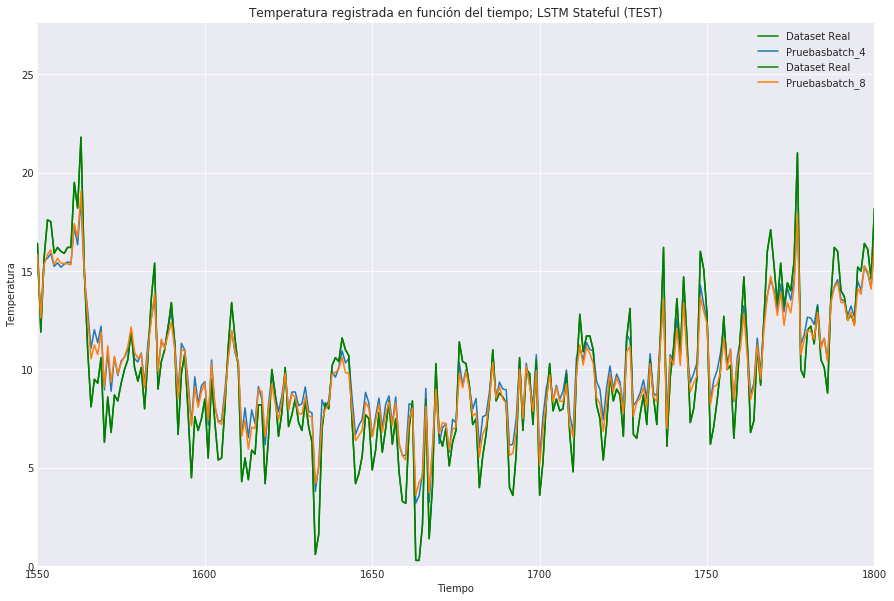

In [152]:
plt.figure(figsize=(15, 10))
etiquetas=["batch_4", "batch_8"]
for i in range(2):    
    trainPredict=trainpredictsM[i]
    testPredict=testpredictsM[i]
    testPredictPlot = np.empty_like(dataframe.values)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[(len(trainPredict)+2*lag):, :][0:496]  = testPredict
    sns.set_style("darkgrid")

    plt.plot(dataframe.values,'g',label = "Dataset Real")
    #plt.plot(trainPredictPlot[0:400], label= "Entrenamiento"+etiquetas[i])
    plt.plot(testPredictPlot, label= "Pruebas"+etiquetas[i])
    
plt.ylim(0)
plt.xlim(1550,1800) #donde mejor se aprecian las diferencias
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo; LSTM Stateful (TEST)")
plt.legend(loc="upper right")
plt.show()

Se aprecia gráficamente que los mejores desempeños corresponden a los del modelo de batch size=8; Esto se puede explicar desde el punto de vista de que cada ejemplo cuenta con una gran cantidad de días 'recuento' por lo que el modelo puede definir de manera más precisa la temperatura del día siguiente. Ahora bien, aunque el número de samples se reduce considerablemente (al tener un batch size alto), se deberá tener bastante cuidado en una próxima experimentación sobre un dataset diferente puesto que NO siempre un batch size mayor será beneficioso. Pueden existir casos en los que aumentar el tamaño del batch afecte considerablemente al número de muestras perjudicando al modelo y obteniendo resultados peores que con un tamaño de batch más reducido.

> o) Construya una LSTM apilada, y compárela con la obtenida en i). Comente brevemente lo sucedido.
```python
model.add(LSTM(4, input_dim=1, return_sequences=True))
model.add(LSTM(4))
```

Una LSTM apilada es una extensión del modelo entrenado anteriormente que tiene múltiples capas ocultas de LSTM haciendo al modelo más profundo. Como hemos visto en tareas pasadas y otras experimentaciones personales, agregar profundidad a las redes neuronales permite reiteradamente acercarse a mejores resultados.

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/07/architecture_stacked_lstm.png",width=100, height=100)

##### Arquitectura LSTM apilada

Dado que LSTMs funcionan con datos de secuencia, agregar una nueva capa agrega un nuevo nivel de abstracción a las observaciones.

Una arquitectura LSTM apilada se puede definir como un modelo LSTM compuesto por múltiples capas LSTM. Una capa LSTM proporciona como salida una secuencia en lugar de un único valor que servirá de entrada a la siguiente capa LSTM. Específicamente, una salida por cada tiempo de entrada, en lugar de una salida para todos los tiempos de entrada.


https://machinelearningmastery.com/stacked-long-short-term-memory-networks/


### 2 capas LSTM y una densa

In [155]:
lag=3
batch_size=8
print ("Utilizando batch_size de", batch_size, "y un total de unidades de", unids)
model = Sequential()
model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid',return_sequences=True))
model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
total=75
inicio = time.time()
for i in range(total):
    model.fit(trainX2, trainY2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
trainPredict = model.predict(trainX2, batch_size=batch_size)
trainPredictSta = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY2.copy())
testPredict = model.predict(testX2, batch_size=batch_size)
testPredictSta = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY2.copy())
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredictSta[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredictSta[:,0]))
print('Test Score: %.3f RMSE' % (testScore))


Utilizando batch_size de 8 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 37.428785
Train Score: 2.558 RMSE
Test Score: 2.396 RMSE


### 3 capas LSTM y una densa 


In [156]:

lag=3
batch_size=8
print ("Utilizando batch_size de", batch_size, "y un total de unidades de", unids)
model = Sequential()
model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid',return_sequences=True))
model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid',return_sequences=True))
model.add(LSTM(unids, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
total=75
inicio = time.time()
for i in range(total):
    model.fit(trainX2, trainY2, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
trainPredict = model.predict(trainX2, batch_size=batch_size)
trainPredictSta = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY2.copy())
testPredict = model.predict(testX2, batch_size=batch_size)
testPredictSta = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY2.copy())
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredictSta[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredictSta[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Utilizando batch_size de 8 y un total de unidades de 6
Tiempo que requirió el entrenamiento: 48.806673
Train Score: 2.552 RMSE
Test Score: 2.466 RMSE


En la celda anterior se entrenan dos redes LSTM apilada (2 capas LSTM y una capa densa y 3 capas LSTM y una densa) basándose en la arquitectura de la pregunta **k**  

### 2 capas LSTM y capa densa:

Si bien el error obtenido por esta red es bastante similar al acusado por la red en **k**, es mucho menor al obtenido en **i**, la cual fue configurada para 4 unidades de salida. Sin embargo, la que fue configurada para 6 unidades (a fin de que sean comparables las capas utilizadas), acusa igualmente un error más alto que el de la red apilada.  
A modo resumen: 

**LSTM apilada**
- Train Score: **2.558 RMSE, Test Score: 2.396 RMSE**
**item i**
- (4 unidades) Train Score: 2.62 RMSE, Test Score: 2.42 RMSE 
- (6 unidades) Train Score: 2.61 RMSE, Test Score: 2.41 RMSE
**item k**
- (6 unidades; Modelo Stateful, Batch size=8 y lag=3) **Train Score: 2.559 RMSE, Test Score: 2.374 RMSE**




### 3 capas LSTM y capa densa:

Si bien el error obtenido por esta red es bastante similar al acusado por la red en **k** en cuanto a loss en el conjunto de entrenamiento, existe una diferencia considerable sobre el conjunto de pruebas siendo el ítem anterior el de mejor desempeño. Nuevamente, el agregar otra capa oculta a la red permite obtener errores menores a los obtenidos en el ítem **i** y su respectivo modelo de 6 unidades (en **j**).  
A modo resumen: 

**LSTM apilada**
- Train Score: **Train Score: 2.552 RMSE, Test Score: 2.466 RMSE**
**item i**
- (4 unidades) Train Score: 2.62 RMSE, Test Score: 2.42 RMSE 
- (6 unidades) Train Score: 2.61 RMSE, Test Score: 2.41 RMSE
**item k**
- (6 unidades; Modelo Stateful, Batch size=8 y lag=3) **Train Score: 2.559 RMSE, Test Score: 2.374 RMSE**


Así entonces, para este caso particular, podemos afirmar que el aumento de capas ocultas, si bien aumenta considerablemente el número de parámetros, debido a la cantidad de datos con los cuales se cuenta, permite obtener modelos con resultados bastante competentes.

> p) Sobre algunas de las redes definidas anteriormente deberá graficar el valor real *vs* la predicción del conjunto de pruebas tomando el primer dato (con sus $t$ *timesteps*) como inicio de la predicción y luego para predecir el siguiente valor se toman los $t-1$ *timesteps* mas el valor de predicción del primer dato, y así hasta cubrir todos los datos de pruebas. Dicho de otra forma, para los $N_t$ datos/mediciones del conjunto de pruebas, se requiere predecir los $N_t-t$ valores a partir de algun valor $p$, de la siguiente manera:
$$
\hat{x}_{p} = f(x_{p-t},x_{p-t+1},\cdots,x_{p-1}) \\
\hat{x}_{p+1} = f(x_{p+1-t},x_{p+1-t+1},\cdots,x_{p-1},\hat{x}_{p}) \\
\hat{x}_{p+2} = f(x_{p+2-t},x_{p+2-t+1},\cdots,\hat{x}_{p},\hat{x}_{p+1}) \\
\cdots \\
\hat{x}_{N_t} = f(\hat{x}_{N_t-t},\hat{x}_{N_t-t+1},\cdots,\hat{x}_{N_t-2},\hat{x}_{N_t-1})
$$

Debido a que el problema del presente ítem estaba estructurado para un modelo de batch size=1, se optó por seguir la configuración del mejor modelo de dicho tamaño de batch. Esto es:


In [158]:
import math
from sklearn.metrics import mean_squared_error
import time, math

lag=3
batch_size=1
modelf = Sequential()
modelf.add(LSTM(6, batch_input_shape=(batch_size, lag, 1), stateful=True, activation='tanh' , recurrent_activation='sigmoid'))
modelf.add(Dense(1,activation='linear'))

modelf.compile(loss='mean_squared_error', optimizer='adam')
inicio = time.time()
for i in range(75):
    modelf.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    modelf.reset_states()    
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

trainPredict = modelf.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_d = scaler.inverse_transform(trainY.copy())
testPredict = modelf.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_d = scaler.inverse_transform(testY.copy())
trainscore = math.sqrt(mean_squared_error(trainY_d, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainscore))
testscore = math.sqrt(mean_squared_error(testY_d, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testscore))

Tiempo que requirió el entrenamiento: 195.224990
Train Score: 2.884 RMSE
Test Score: 2.676 RMSE


In [160]:
input_array=trainX[0:1]
print (input_array)
trainY_d = scaler.inverse_transform(trainY.copy())
predicciones=[]
for j in range(1497): ##fijar en 1497 cuando este ok
    trainPredict = modelf.predict(input_array, batch_size=batch_size)
    trainPredictSta = scaler.inverse_transform(trainPredict) 
    #appendear la prediccion a un array de prediccion xd
    predicciones.append(trainPredictSta)
    #agregar trainPredict al vector input y borrar el primer elemento
    temp=list(input_array[0])
    temp.append(trainPredict[0])
    temp.remove(temp[0])
    temp1=input_array.copy()
    temp1[0]=np.asarray(temp)
    input_array=temp1  
    

[[[0.7870723]
  [0.6806084]
  [0.7148289]]]


In [161]:
print ("Las predicciones del modelo basandose en sí mismo son\n",np.asarray(predicciones)[:,0][0:10])
print ("\n Los originales son\n", trainY_d[0:10])

Las predicciones del modelo basandose en sí mismo son
 [[16.657196 ]
 [15.4443245]
 [15.155609 ]
 [14.885696 ]
 [14.605165 ]
 [14.432658 ]
 [14.327339 ]
 [14.247302 ]
 [14.188816 ]
 [14.149291 ]]

 Los originales son
 [[14.599999]
 [15.8     ]
 [15.8     ]
 [15.8     ]
 [17.4     ]
 [21.8     ]
 [20.      ]
 [16.2     ]
 [13.3     ]
 [16.7     ]]


In [162]:
trainscore = math.sqrt(mean_squared_error(trainY_d, np.asarray(predicciones)[:,0]))
print('Train Score: %.3f RMSE' % (trainscore))

Train Score: 5.197 RMSE


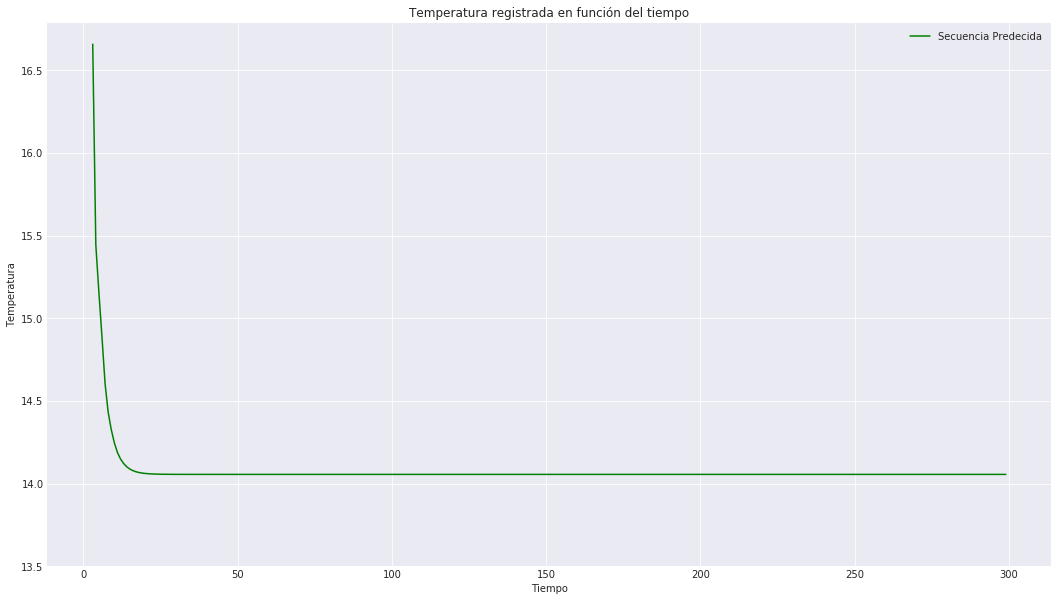

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(predicciones)+lag, :] = predicciones
sns.set_style("darkgrid")

#plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot[0:300],'g', label= "Secuencia Predecida")
plt.ylim(13.5)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

Los resultados obtenidos por el modelo de batch size=1 basado en sus propias predicciones acusan que no es capaz de aprender ni extraer información de utilidad porque, según se aprecia, se ajusta a los valores medios de predicción en base a la secuencia de entrada del mismo. Es decir, se ajusta al promedio de los datos observados fijándose en un valor fijo (14°C app.)  
Esto podría deberse muy probablemente a la poca información con la que cuenta el modelo en cada predicción por lo que se variará el modelo hacia un lag mayor.


### Utilizando lag=4

In [164]:
lag=4
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,valX,valY = crear_datos_lag(stream_train_scaled, stream_val_scaled, lag)
model = Sequential()
model.add(LSTM(6, activation='tanh',  input_shape=(None, lag), recurrent_activation="sigmoid"))
model.add(Dense(1,activation='linear'))
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

valPredict = model.predict(valX, batch_size=batch_size)
valPredict = scaler.inverse_transform(valPredict)
valY_ds = scaler.inverse_transform(valY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(valY_ds, valPredict[:,0]))
print('Test Score: %.2f RMSE' % (valScore))


Con un lag equivalente a: 4
Las dimensiones finales del conjunto X de entrenamiento son: (1496, 1, 4)
Las dimensiones finales del conjunto Y de entrenamiento son: (1496, 1)
Las dimensiones finales del conjunto X de validación son: (1646, 1, 4)
Las dimensiones finales del conjunto Y de validación son: (1646, 1)
Tiempo que requirió el entrenamiento: 58.682204
Train Score: 2.59 RMSE
Test Score: 2.42 RMSE


In [165]:
input_array=trainX[0:1]
trainY_d2 = scaler.inverse_transform(trainY.copy())
predicciones2=[]
for j in range(1496): ##fijar en 1497 cuando este ok
    trainPredict = model.predict(input_array, batch_size=1)    
    trainPredictSta = scaler.inverse_transform(trainPredict) 
    #appendear la prediccion a un array de prediccion xd
    predicciones2.append(trainPredictSta)
    #agregar trainPredict al vector input y borrar el primer elemento
    temp=list(input_array[0])
    temp.append(trainPredict[0])
    temp.remove(temp[0])
    temp1=input_array.copy()
    temp1[0]=np.asarray(temp)
    input_array=temp1  
    
print ("Las predicciones del modelo basandose en sí mismo son\n",np.asarray(predicciones2)[:,0][0:10])
print ("\n Los originales son\n", trainY_d2[0:10]) 

trainscore2 = math.sqrt(mean_squared_error(trainY_d2, np.asarray(predicciones2)[:,0]))
print('Train Score: %.3f RMSE' % (trainscore2))

Las predicciones del modelo basandose en sí mismo son
 [[15.510404]
 [15.144936]
 [14.812421]
 [14.50858 ]
 [14.229977]
 [13.973799]
 [13.737724]
 [13.519798]
 [13.318354]
 [13.131952]]

 Los originales son
 [[15.8]
 [15.8]
 [15.8]
 [17.4]
 [21.8]
 [20. ]
 [16.2]
 [13.3]
 [16.7]
 [21.5]]
Train Score: 4.224 RMSE


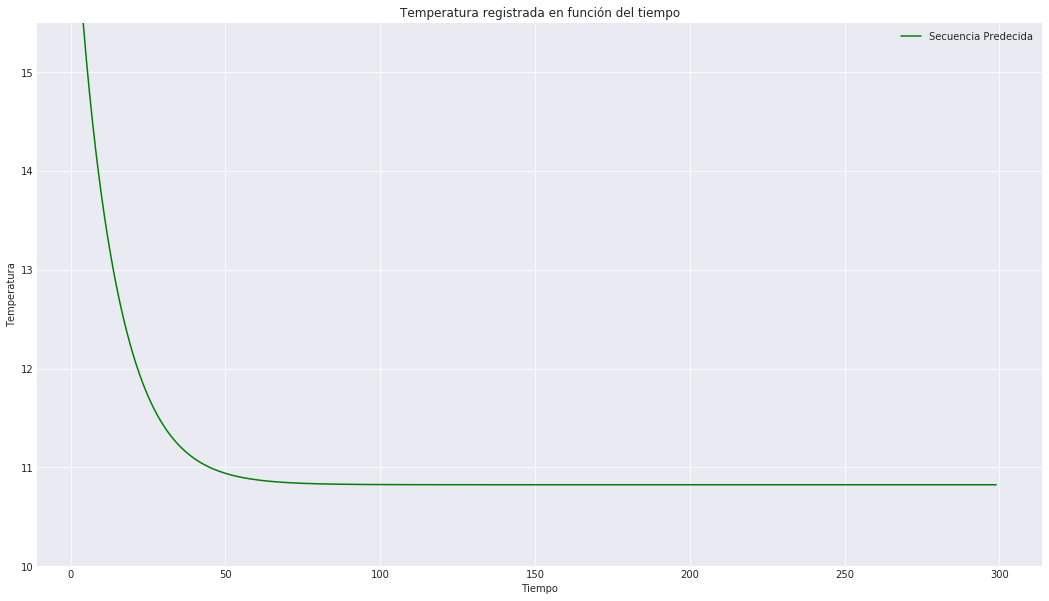

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(predicciones2)+lag, :] = predicciones2
sns.set_style("darkgrid")

#plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot[0:300],'g', label= "Secuencia Predecida")
plt.ylim(10, 15.5)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

Nuevamente se aprecia una situación similar estableciéndose en los 11°C app; Se propone trabajar con un lag=20 a fin de ser extremos en esta teoría.

In [169]:
##
lag=20
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,valX,valY = crear_datos_lag(stream_train_scaled, stream_val_scaled, lag)
model = Sequential()
model.add(LSTM(6, activation='tanh',  input_shape=(None, lag), recurrent_activation="sigmoid"))
model.add(Dense(1,activation='linear'))
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

valPredict = model.predict(valX, batch_size=batch_size)
valPredict = scaler.inverse_transform(valPredict)
valY_ds = scaler.inverse_transform(valY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(valY_ds, valPredict[:,0]))
print('Test Score: %.2f RMSE' % (valScore))


Con un lag equivalente a: 20
Las dimensiones finales del conjunto X de entrenamiento son: (1480, 1, 20)
Las dimensiones finales del conjunto Y de entrenamiento son: (1480, 1)
Las dimensiones finales del conjunto X de validación son: (1630, 1, 20)
Las dimensiones finales del conjunto Y de validación son: (1630, 1)
Tiempo que requirió el entrenamiento: 59.380328
Train Score: 2.54 RMSE
Test Score: 2.44 RMSE


In [171]:
input_array=trainX[0:1]
trainY_d3= scaler.inverse_transform(trainY.copy())
predicciones3=[]
for j in range(1480): ##fijar en 1497 cuando este ok
    trainPredict = model.predict(input_array, batch_size=1)    
    trainPredictSta = scaler.inverse_transform(trainPredict) 
    #appendear la prediccion a un array de prediccion xd
    predicciones3.append(trainPredictSta)
    #agregar trainPredict al vector input y borrar el primer elemento
    temp=list(input_array[0])
    temp.append(trainPredict[0])
    temp.remove(temp[0])
    temp1=input_array.copy()
    temp1[0]=np.asarray(temp)
    input_array=temp1  
    
print ("Las predicciones del modelo basandose en sí mismo son\n",np.asarray(predicciones3)[:,0][0:10])
print ("\n Los originales son\n", trainY_d3[0:10]) 

trainscore3 = math.sqrt(mean_squared_error(trainY_d3, np.asarray(predicciones3)[:,0]))
print('Train Score: %.3f RMSE' % (trainscore3))

Las predicciones del modelo basandose en sí mismo son
 [[17.528126]
 [17.603573]
 [17.662436]
 [17.708212]
 [17.743715]
 [17.771196]
 [17.792435]
 [17.80883 ]
 [17.821474]
 [17.831215]]

 Los originales son
 [[18.2     ]
 [12.1     ]
 [14.400001]
 [16.      ]
 [16.5     ]
 [18.7     ]
 [19.4     ]
 [17.2     ]
 [15.500001]
 [15.1     ]]
Train Score: 8.043 RMSE


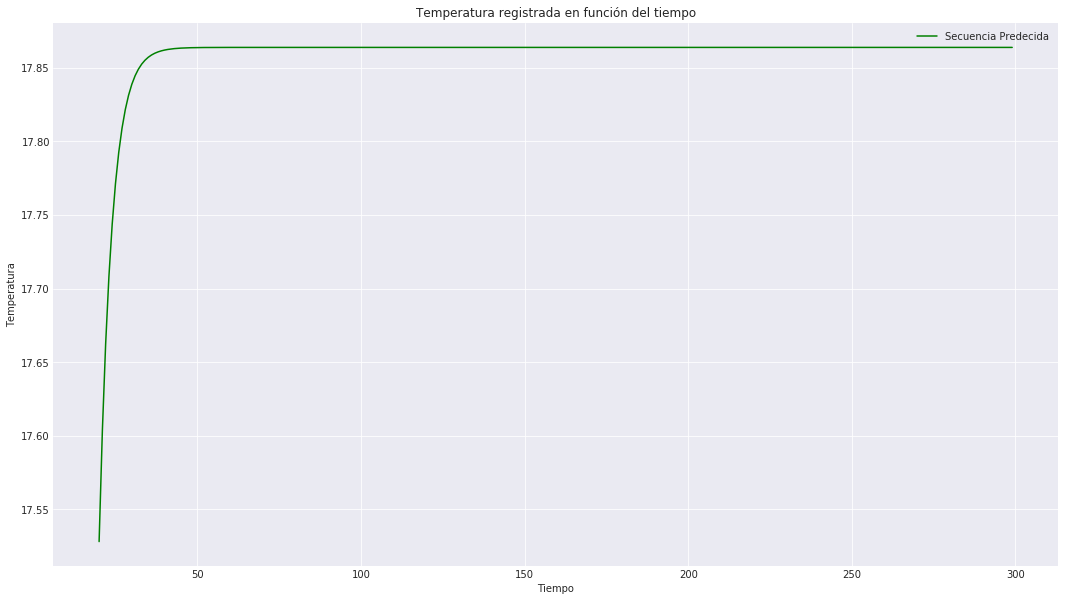

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(predicciones3)+lag, :] = predicciones3
sns.set_style("darkgrid")
#plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot[0:300],'g', label= "Secuencia Predecida")
#plt.ylim(0,11)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

Aparentemente el modelo no es capaz de aprender, al basarse en sus mismas predicciones el error se va acumulando en cada una de las iteraciones a modo de que éstas quedan estancadas en su valor medio dado el vector (sub secuencia) de entrada al método predict del éste.

<a id="refs"></a>
## Referencias
[1] Vincent, P., Larochelle, H., Lajoie, I., Bengio, Y., Manzagol, P. A. *Stacked denoising autoencoders: Learning useful representations in a deep network with a local denoising criterion*. Journal of Machine Learning Research 11. pp 3371–3408, 2010.  
[3]  Bishop, Christopher M. (1995), *Neural Networks for Pattern Recognition,* Clarendon Press.  
[4] Krizhevsky, A., Hinton, G. (2009). *Learning multiple layers of features from tiny images*.  
[5] *Scikit-learn: Machine Learning in Python.* http://scikit-learn.org/stable/  
[6] Holden, D., Saito, J., Komura, T., & Joyce, T. (2015, November). *Learning motion manifolds with convolutional autoencoders.* In SIGGRAPH Asia 2015 Technical Briefs (p. 18). ACM.  
[7] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition.* arXiv preprint arXiv:1409.1556.  
[8] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[9] Schuster, M., & Paliwal, K. K. (1997). *Bidirectional recurrent neural networks.* IEEE Transactions on Signal Processing, 45(11), 2673-2681.  
[10] LeCun, Y., Bengio, Y., & Hinton, G. (2015). *Deep learning*. nature, 521(7553), 436.  
[11] https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html